<a href="https://colab.research.google.com/github/justdepie/Gastronomos_scraping/blob/main/Gastronomos_scraping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Libraries & Functions

In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from tqdm import tqdm
import re
import json

In [ ]:
response = requests.get('https://www.gastronomos.gr/syntagh/salata-me-kokkino-lachano-achladi-kai-saltsa-petimezioy/52147/')#example
soup = BeautifulSoup(response.content, 'html.parser')
print(soup)

In [ ]:
def convert_to_minutes(text):
    pattern = r'(\d+)H(?:(\d+)M)?'
    def replace_function(match):
        hours = int(match.group(1))
        minutes = int(match.group(2)) if match.group(2) else 0
        total_minutes = hours * 60 + minutes
        return str(total_minutes) + ' λεπτά'
    return re.sub(pattern, replace_function, text)



#Scraping

In [ ]:

  recipe_urls = set()

  for i in tqdm(range(1, 187)):
      # URL of the webpage containing all recipe links
      index_url = f"https://www.gastronomos.gr/oles-oi-syntages/page/{i}/?ingredient=0&meal_type=2976&recipe_type=0&nutrition=0&holiday=0&ingredient_qty=0&cook_time=0"

      # Send a GET request to the index URL
      index_response = requests.get(index_url)

      # Check status
      if index_response.status_code == 200:
          # Use regular expressions to find all recipe URLs on the page
          new_recipe_urls = set(re.findall(r"https://www\.gastronomos\.gr/syntagh/.*?/\d+/", index_response.text))

          # Update the set of recipe URLs with the new URLs found on this page
          recipe_urls.update(new_recipe_urls)
      else:
          print("Failed to retrieve webpage. Status code:", index_response.status_code)





100%|██████████| 186/186 [04:09<00:00,  1.34s/it]


In [ ]:
recipe_all = []

for url in tqdm(recipe_urls):
    # Create a dictionary to store the recipe details
    recipe = {}

    # Send a GET request to the URL
    response = requests.get(url,allow_redirects=False)

    # Check status
    if response.status_code == 200:
        # Parse the HTML content of the webpage
        soup = BeautifulSoup(response.content, "html.parser")

        # Find the script containing JSON-LD data
        script_tag = soup.find("script", type="application/ld+json")

        # Extract JSON-LD data if found
        if script_tag:
            json_ld_data = script_tag.string

            # Parse JSON-LD data
            recipe_data = json.loads(json_ld_data)
            recipe['name'] = recipe_data.get('name', '') #get the value if it exists else " "
            recipe['URL'] = recipe_data.get('url', '')
            recipe['Description'] = recipe_data.get('description', '')
            recipe['Preparation Time'] = recipe_data.get('prepTime', '')
            recipe['Total Time'] = recipe_data.get('totalTime', '')
            recipe['Number of Servings'] = recipe_data.get('recipeYield', '')
            recipe['Ingredients'] = recipe_data.get('recipeIngredient', '')
            recipe['Instructions'] = recipe_data.get('recipeInstructions', '')
            recipe['Publication Date']=recipe_data.get('datePublished', '')
            recipe['Author']=recipe_data.get('author', '')
            recipe['Category']=recipe_data.get("recipeCategory", '')
            recipe['Keywords']=recipe_data.get("keywords", '')

            # Add the recipe to the recipe_all dictionary
            recipe_all.append(recipe)

        else:
            print("JSON-LD script not found on the webpage.")
    else:
        print("Failed to retrieve webpage. Status code:", response.status_code)


#concat all instruction text to one string
for i in tqdm(range(len(recipe_all))) :
  s = ''
  for num_of_steps in range(len(recipe_all[i]['Instructions'])):
      s += recipe_all[i]['Instructions'][num_of_steps]['text']
  recipe_all[i]['Instructions'] = s

#concat all ingredients to one string
for i in tqdm(range(len(recipe_all))) :
  k = ''
  for num_of_ingr in range(len(recipe_all[i]['Ingredients'])):
    if k =='':
      k=recipe_all[i]['Ingredients'][num_of_ingr]
    else:
      k= k + ", " + recipe_all[i]['Ingredients'][num_of_ingr]
  recipe_all[i]['Ingredients'] = k

#get the author name
for i in tqdm(range(len(recipe_all))) :
  if recipe_all[i]['Author']!='':
    recipe_all[i]['Author']=recipe_all[i]['Author'][0]['name']


 25%|██▍       | 534/2144 [10:23<26:25,  1.02it/s]

Failed to retrieve webpage. Status code: 301


 39%|███▉      | 842/2144 [16:32<22:50,  1.05s/it]

Failed to retrieve webpage. Status code: 301


 94%|█████████▍| 2024/2144 [40:10<02:04,  1.04s/it]

Failed to retrieve webpage. Status code: 301


100%|██████████| 2141/2141 [00:00<00:00, 297105.21it/s]


In [ ]:
dfs = []

for i in range(len(recipe_all)):
    # Convert the dictionary to a DataFrame
    recipe_df = pd.DataFrame.from_dict(recipe_all[i], orient='index').T

    # Append the DataFrame to the list
    dfs.append(recipe_df)

# Concatenate all DataFrames in the list
df = pd.concat(dfs, ignore_index=True)


In [ ]:
df

,name,URL,Description,Preparation Time,Total Time,Number of Servings,Ingredients,Instructions,Publication Date,Author,Category,Keywords
0,Χορτόσουπα περαστή με συκωταριά στο τηγάνι για...,https://www.gastronomos.gr/syntagh/chortosoypa...,\r\n\r\n\r\n\r\nΑκαταμάχητος ο συνδυασμός τη...,PT40M,PT1H30M,8,"2.800 ml <a href=""https://www.gastronomos.gr/s...","Για τη σούπα, βάζουμε τον ζωμό να πάρει μία βρ...",2023-04-11 16:09:56,Νένα Ισμυρνόγλου,Κυρίως Γεύμα,"Αρνί,Χόρτα / Μυρωδικά,Πάσχα"
1,Τορτίγια με πατάτες και κολοκυθάκια,https://www.gastronomos.gr/syntagh/tortigia-me...,Οι τορτίγιες είναι ομελέτες με πατάτες που λα...,PT15M,PT1H2M,"για μια μεγάλη τορτιγια, για 4 άτομα",3 πατάτες καθαρισμένες και κομμένες σε κυβάκια...,Για να φτιάξουμε τορτίγια με πατάτες και κολοκ...,2022-06-23 15:07:26,Χριστόφορος Πέσκιας,Ορεκτικό / Μεζές,"Αυγά,Κολοκυθάκια,Πατάτες"
2,Ψευτοσουφλέ με ζαμπόν και 3 τυριά,https://www.gastronomos.gr/syntagh/pseytosoyfl...,Νόστιμη και εύκολη συνταγή για το καθημερινό τ...,PT10M,PT1H10M,4-6,"1 πακέτο (350 γρ.) φέτες ψωμί του τοστ, της αρ...",Για το ψευτοσουφλέ με ζαμπόν και 3 τυριά ξεκιν...,2023-01-18 15:09:10,,Κυρίως Γεύμα,"Γάλα,Τυρί"
3,Κυδώνια αχνιστά με ούζο και κρεμμύδι,https://www.gastronomos.gr/syntagh/kydonia-ach...,"Αχιβάδες, κυδώνια, μύδια, γυαλιστερές, πίνες, ...",PT20M,PT35M,4,1 κιλό κυδώνια (ή αχιβάδες ή γυαλιστερές ή άλλ...,"Για τα κυδώνια αχνιστά με ούζο και κρεμμύδι, π...",2023-02-07 19:13:49,Αλέξανδρος Παπανδρέου,Ορεκτικό / Μεζές,"Κυδώνια / Όστρακα,Ούζο,Καθαρά Δευτέρα,Νηστίσιμα"
4,Μύδια γεμιστά με πλιγούρι,https://www.gastronomos.gr/syntagh/mydia-gemis...,"Αντί για το συνηθισμένο ρύζι, τα μύδια εδώ γεμ...",PT40M,PT1H5M,4,"35 μύδια φρέσκα, με το κέλυφος, καλά βουρτσισμ...","Για να φτιάξουμε τα μύδια γεμιστά με πλιγούρι,...",2023-07-28 15:40:46,Νένα Ισμυρνόγλου,Κυρίως Γεύμα,"Μύδια,Πλιγούρι"
...,...,...,...,...,...,...,...,...,...,...,...,...
2136,Πλιγούρι με γαρίδες,https://www.gastronomos.gr/syntagh/pligoyri-me...,"Ωραιότατο πιάτο, που αξιοποιεί το πλιγούρι που...",PT15M,PT35M,20-25 μπολάκια,"500 γρ. πλιγούρι, 50 ml ελαιόλαδο + λίγο επιπλ...","Για να φτιάξουμε το πλιγούρι με γαρίδες, ξεκιν...",2023-01-18 17:23:33,Λευτέρης Λαζάρου,Ορεκτικό / Μεζές,"Γαρίδες,Πλιγούρι"
2137,Μύδια αχνιστά με μπίρα και ντοματίνια,https://www.gastronomos.gr/syntagh/mydia-achni...,Η γεύση των φρέσκων μυδιών αναδεικνύεται με τα...,PT40M,PT55M,6,"1 κιλό μύδια, 200 ml μπίρα ξανθιά, 1 μικρό ξερ...",Για να φτιάξουμε τα μύδια αχνιστά με μπίρα και...,2023-03-23 18:50:45,Περικλής Κοσκινάς,Ορεκτικό / Μεζές,"Θαλασσινά,Μύδια,Ντομάτα,25η Μαρτίου,Καθαρά Δευ..."
2138,Φραντζολάκια γεμιστά με ταρατόρ και μύδια τηγα...,https://www.gastronomos.gr/syntagh/frantzolaki...,Το μυδοσάντουιτς είναι το απόλυτο street food ...,PT40M,PT1H,4,"3/4 φλιτζ. τσαγιού καρυδόψιχα, 1 κουτ. γλυκού ...",Προθερμαίνουμε τον φούρνο στους 170°C. Σε μπολ...,2023-07-26 18:27:18,Σταυριανή Ζερβακάκου,Ορεκτικό / Μεζές,"Θαλασσινά,Μύδια"
2139,Χταπόδι μπουγιουρντί,https://www.gastronomos.gr/syntagh/chtapodi-mp...,Μια παραλλαγή στις γαρίδες σαγανάκι είναι ...,PT10M,PT1H30M,4 ως μεζές,"1 χταπόδι περίπου 1 κιλό , 1 πιπεριά Φλωρίνης,...","Για το χταπόδι μπουγιουρντί, προθερμαίνουμε το...",2022-05-16 16:12:56,,Ορεκτικό / Μεζές,"Πιπεριές,Φέτα,Χταπόδι"


In [ ]:
#save dessert data
import pickle
df.to_pickle('appetizer_df.pkl')

#Preprocessing

In [ ]:
main_course=pd.read_pickle('/content/drive/MyDrive/Gastronomos Model/main_dish_df.pkl')
dessert=pd.read_pickle('/content/drive/MyDrive/Gastronomos Model/dessert_df.pkl')
salad=pd.read_pickle('/content/drive/MyDrive/Gastronomos Model/salad_df.pkl')
appetizer=pd.read_pickle('/content/drive/MyDrive/Gastronomos Model/appetizer_df.pkl')

df = main_course.append(dessert, ignore_index=True)
df =df.append(salad,ignore_index=True)
df=df.drop_duplicates()
df

<ipython-input-298-0f6c2e0fb92b>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = main_course.append(dessert, ignore_index=True)
<ipython-input-298-0f6c2e0fb92b>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df =df.append(salad,ignore_index=True)


,name,URL,Description,Preparation Time,Total Time,Number of Servings,Ingredients,Instructions,Publication Date,Author,Category,Keywords
0,Χορτόσουπα περαστή με συκωταριά στο τηγάνι για...,https://www.gastronomos.gr/syntagh/chortosoypa...,\r\n\r\n\r\n\r\nΑκαταμάχητος ο συνδυασμός τη...,PT40M,PT1H30M,8,"2.800 ml <a href=""https://www.gastronomos.gr/s...","Για τη σούπα, βάζουμε τον ζωμό να πάρει μία βρ...",2023-04-11 16:09:56,Νένα Ισμυρνόγλου,Κυρίως Γεύμα,"Αρνί,Χόρτα / Μυρωδικά,Πάσχα"
1,Λαζάνια με ρικότα και μοτσαρέλα,https://www.gastronomos.gr/syntagh/lazania-me-...,"Αν η σαλάτα καπρέζε ήταν μαγειρευτό φαγητό, θα...",PT15M,PT1H15M,6,"200 γρ. ξερά κρεμμύδια, ψιλοκομμένα, 80 ml ελα...",Σε φαρδιά κατσαρόλα σοτάρουμε τα κρεμμύδια στο...,2022-02-17 17:14:07,Χριστόφορος Πέσκιας,Κυρίως Γεύμα,"Ζυμαρικά,Ντομάτα,Τυρί"
2,Καλαμαράκια με μουστάρδα και κοφτό μακαρονάκι,https://www.gastronomos.gr/syntagh/kalamaria-m...,"Το πορτοκάλι, το τζίντζερ και ο βασιλικός μας ...",PT30M,PT55M,4-6,"1 κιλό καλαμάρια, καθαρισμένα, 200 γρ. κρεμμύδ...",Σε φαρδιά κατσαρόλα ζεσταίνουμε το λάδι σε μέτ...,2022-04-19 16:38:16,Λευτέρης Λαζάρου,Κυρίως Γεύμα,"Ζυμαρικά,Καλαμάρι / Θράψαλο"
3,Ψευτοσουφλέ με ζαμπόν και 3 τυριά,https://www.gastronomos.gr/syntagh/pseytosoyfl...,Νόστιμη και εύκολη συνταγή για το καθημερινό τ...,PT10M,PT1H10M,4-6,"1 πακέτο (350 γρ.) φέτες ψωμί του τοστ, της αρ...",Για το ψευτοσουφλέ με ζαμπόν και 3 τυριά ξεκιν...,2023-01-18 15:09:10,,Κυρίως Γεύμα,"Γάλα,Τυρί"
4,Η θρυλική ρεβυθάδα Σίφνου,https://www.gastronomos.gr/syntagh/i-thryliki-...,Η ρεβυθάδα της Σίφνου είναι θρυλική. Για να τη...,PT10M,PT10H10M,6-8,700 γρ. ρεβύθια (μουλιασμένα αποβραδίς σε νερό...,Για την φτιάξουμε την θρυλική ρεβυθάδα της Σίφ...,2024-01-29 17:56:35,,Κυρίως Γεύμα,"Ρεβύθια,Vegan,Νηστίσιμα"
...,...,...,...,...,...,...,...,...,...,...,...,...
5502,Ρυζοσαλάτα με λαχανικά,https://www.gastronomos.gr/syntagh/ryzosala-ta...,"Χορταστική σαλάτα με ρύζι, πιπεριές, αρακά και...",PT30M,PT55M,6,"1/2 κιλό ρύζι για πιλάφι (παρμπόιλντ), 2 κ...",Βράζουμε το ρύζι σε μπόλικο αλατισμένο νερ...,2022-04-15 21:06:00,Ντίνα Νικολάου,Σαλάτα,"Λαχανικά,Ρύζι,Σαρδέλα,Πάσχα"
5503,"Σαλάτα με αλμυρίκια, γαύρο μαρινάτο και βινεγκ...",https://www.gastronomos.gr/syntagh/salata-me-a...,Η θάλασσα στο πιάτο σας.,PT25M,PT25M,4,"1 κιλό αλμυρίκια, καθαρισμένα από τα χοντρά, Π...","Κόβουμε την ντομάτα στη μέση, τη στύβουμε ελαφ...",2023-04-24 21:56:13,Χριστόφορος Πέσκιας,Σαλάτα,"Γαύρος,Διάφορα χόρτα εποχής,Ντομάτα"
5504,"Σπαράγγια με αβοκάντο, μανιτάρια και ντρέσινγκ...",https://www.gastronomos.gr/syntagh/sparaggia-m...,Μια δημιουργική σαλάτα που που ταιριάζει με τ...,PT25M,PT30M,6,"500 γρ. <a href=""https://www.gastronomos.gr/sy...","Για τα σπαράγγια με αβοκάντο, μανιτάρια και ντ...",2023-04-10 16:29:55,Νένα Ισμυρνόγλου,Σαλάτα,"Αβοκάντο,Μανιτάρια,Σπαράγγια,Πάσχα,Light,Vegan..."
5505,Τυροκαυτερή κυκλαδίτικη,https://www.gastronomos.gr/syntagh/tyrokayteri...,Η ιδιαιτερότητά αυτή της τυροκαυτερής είναι ότ...,PT10M,PT10M,4,"400 γρ. λευκά, φρέσκα κυκλαδίτικα τυράκια, όπω...","Για να φτιάξουμε κυκλαδίτικη τυροκαυτερή, αρχι...",2023-04-05 15:23:51,Λίνα Φουρνιστάκη,Σαλάτα,"Ελιά,Ντομάτα,Τυρί,Πάσχα,Χορτοφαγικά"


In [ ]:
df=df.drop_duplicates(subset='name')
df=df.reset_index(drop=True)
df.head()

,name,URL,Description,Preparation Time,Total Time,Number of Servings,Ingredients,Instructions,Publication Date,Author,Category,Keywords
0,Χορτόσουπα περαστή με συκωταριά στο τηγάνι για...,https://www.gastronomos.gr/syntagh/chortosoypa...,\r\n\r\n\r\n\r\nΑκαταμάχητος ο συνδυασμός τη...,PT40M,PT1H30M,8,"2.800 ml <a href=""https://www.gastronomos.gr/s...","Για τη σούπα, βάζουμε τον ζωμό να πάρει μία βρ...",2023-04-11 16:09:56,Νένα Ισμυρνόγλου,Κυρίως Γεύμα,"Αρνί,Χόρτα / Μυρωδικά,Πάσχα"
1,Λαζάνια με ρικότα και μοτσαρέλα,https://www.gastronomos.gr/syntagh/lazania-me-...,"Αν η σαλάτα καπρέζε ήταν μαγειρευτό φαγητό, θα...",PT15M,PT1H15M,6,"200 γρ. ξερά κρεμμύδια, ψιλοκομμένα, 80 ml ελα...",Σε φαρδιά κατσαρόλα σοτάρουμε τα κρεμμύδια στο...,2022-02-17 17:14:07,Χριστόφορος Πέσκιας,Κυρίως Γεύμα,"Ζυμαρικά,Ντομάτα,Τυρί"
2,Καλαμαράκια με μουστάρδα και κοφτό μακαρονάκι,https://www.gastronomos.gr/syntagh/kalamaria-m...,"Το πορτοκάλι, το τζίντζερ και ο βασιλικός μας ...",PT30M,PT55M,4-6,"1 κιλό καλαμάρια, καθαρισμένα, 200 γρ. κρεμμύδ...",Σε φαρδιά κατσαρόλα ζεσταίνουμε το λάδι σε μέτ...,2022-04-19 16:38:16,Λευτέρης Λαζάρου,Κυρίως Γεύμα,"Ζυμαρικά,Καλαμάρι / Θράψαλο"
3,Ψευτοσουφλέ με ζαμπόν και 3 τυριά,https://www.gastronomos.gr/syntagh/pseytosoyfl...,Νόστιμη και εύκολη συνταγή για το καθημερινό τ...,PT10M,PT1H10M,4-6,"1 πακέτο (350 γρ.) φέτες ψωμί του τοστ, της αρ...",Για το ψευτοσουφλέ με ζαμπόν και 3 τυριά ξεκιν...,2023-01-18 15:09:10,,Κυρίως Γεύμα,"Γάλα,Τυρί"
4,Η θρυλική ρεβυθάδα Σίφνου,https://www.gastronomos.gr/syntagh/i-thryliki-...,Η ρεβυθάδα της Σίφνου είναι θρυλική. Για να τη...,PT10M,PT10H10M,6-8,700 γρ. ρεβύθια (μουλιασμένα αποβραδίς σε νερό...,Για την φτιάξουμε την θρυλική ρεβυθάδα της Σίφ...,2024-01-29 17:56:35,,Κυρίως Γεύμα,"Ρεβύθια,Vegan,Νηστίσιμα"


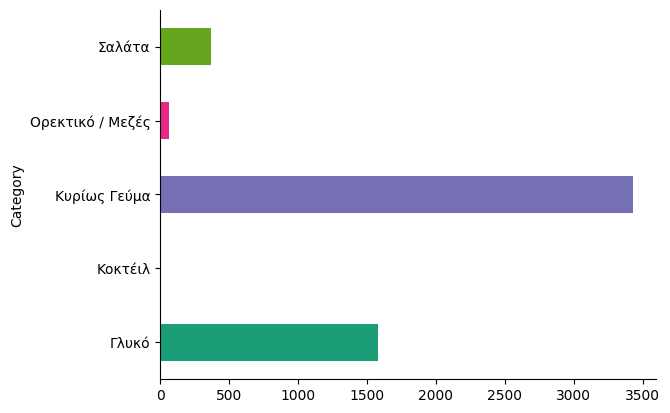

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('Category').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)


In [ ]:
df[df['Category'] == 'Κοκτέιλ'] #there are some categories that shouldn't appear like kokteil

,name,URL,Description,Preparation Time,Total Time,Number of Servings,Ingredients,Instructions,Publication Date,Author,Category,Keywords
5079,Καβουροσαλάτα Bloody Mary,https://www.gastronomos.gr/syntagh/kavoyrosala...,Μία δροσερή καβουροσαλάτα με άρωμα Bloody Mary.,PT10M,PT10M,4,"3 κουτ. σούπας κέτσαπ, 1/2 κ. γλυκού Worcester...","Ανακατεύουμε την κέτσαπ, τη Worcestershire sau...",2022-02-22 13:41:58,Tina Webb,Κοκτέιλ,"Καβούρι,Light,Νηστίσιμα"


In [ ]:
df.Category.iloc[5079]='Σαλάτα' #correcting the category

In [ ]:
#remove html tags
for col in df.columns:
  df[col] = df[col].str.replace(r'<[^>]*>', '',regex=True)
#remove weird substring
df['Description'] = df['Description'].str.replace('\r\n\r\n\r\n\r\n', '')

In [ ]:
#processing preparation time and total time
df['Preparation Time'] = df['Preparation Time'].str.replace('PT', '')
df['Total Time'] = df['Total Time'].str.replace('PT', '')
df['Total Time'] = df['Total Time'].apply(convert_to_minutes)
df['Preparation Time'] = df['Preparation Time'].apply(convert_to_minutes)
df['Preparation Time'] = df['Preparation Time'].str.replace('M', ' λεπτά')
df['Total Time'] = df['Total Time'].str.replace('M', ' λεπτά')
df.head()

,name,URL,Description,Preparation Time,Total Time,Number of Servings,Ingredients,Instructions,Publication Date,Author,Category,Keywords
0,Χορτόσουπα περαστή με συκωταριά στο τηγάνι για...,https://www.gastronomos.gr/syntagh/chortosoypa...,Ακαταμάχητος ο συνδυασμός της βελούδινης σο...,40 λεπτά,90 λεπτά,8,2.800 ml ζωμός κοτόπουλου ή λαχανικών ή άλλος ...,"Για τη σούπα, βάζουμε τον ζωμό να πάρει μία βρ...",2023-04-11 16:09:56,Νένα Ισμυρνόγλου,Κυρίως Γεύμα,"Αρνί,Χόρτα / Μυρωδικά,Πάσχα"
1,Λαζάνια με ρικότα και μοτσαρέλα,https://www.gastronomos.gr/syntagh/lazania-me-...,"Αν η σαλάτα καπρέζε ήταν μαγειρευτό φαγητό, θα...",15 λεπτά,75 λεπτά,6,"200 γρ. ξερά κρεμμύδια, ψιλοκομμένα, 80 ml ελα...",Σε φαρδιά κατσαρόλα σοτάρουμε τα κρεμμύδια στο...,2022-02-17 17:14:07,Χριστόφορος Πέσκιας,Κυρίως Γεύμα,"Ζυμαρικά,Ντομάτα,Τυρί"
2,Καλαμαράκια με μουστάρδα και κοφτό μακαρονάκι,https://www.gastronomos.gr/syntagh/kalamaria-m...,"Το πορτοκάλι, το τζίντζερ και ο βασιλικός μας ...",30 λεπτά,55 λεπτά,4-6,"1 κιλό καλαμάρια, καθαρισμένα, 200 γρ. κρεμμύδ...",Σε φαρδιά κατσαρόλα ζεσταίνουμε το λάδι σε μέτ...,2022-04-19 16:38:16,Λευτέρης Λαζάρου,Κυρίως Γεύμα,"Ζυμαρικά,Καλαμάρι / Θράψαλο"
3,Ψευτοσουφλέ με ζαμπόν και 3 τυριά,https://www.gastronomos.gr/syntagh/pseytosoyfl...,Νόστιμη και εύκολη συνταγή για το καθημερινό τ...,10 λεπτά,70 λεπτά,4-6,"1 πακέτο (350 γρ.) φέτες ψωμί του τοστ, της αρ...",Για το ψευτοσουφλέ με ζαμπόν και 3 τυριά ξεκιν...,2023-01-18 15:09:10,,Κυρίως Γεύμα,"Γάλα,Τυρί"
4,Η θρυλική ρεβυθάδα Σίφνου,https://www.gastronomos.gr/syntagh/i-thryliki-...,Η ρεβυθάδα της Σίφνου είναι θρυλική. Για να τη...,10 λεπτά,610 λεπτά,6-8,700 γρ. ρεβύθια (μουλιασμένα αποβραδίς σε νερό...,Για την φτιάξουμε την θρυλική ρεβυθάδα της Σίφ...,2024-01-29 17:56:35,,Κυρίως Γεύμα,"Ρεβύθια,Vegan,Νηστίσιμα"


In [ ]:
df.Description.value_counts().head(20)

                                                                                                                                                                                    126
Ξένη δημοσίευση                                                                                                                                                                       6
Ένα διαφορετικό, έξοχο σαβόρο!                                                                                                                                                        2
Καρυδόπιτα με γλάσο σοκολάτας, ένα γευστικό, πλούσιο γλυκό, που θα απολαύσουμε με τον καφέ μας ή και σαν επιδόρπιο σε ένα τραπέζι.                                                    2
Ανακουφιστική μετά το πολύ ποτό, αλλά και ωραία έναρξη σε ένα γεύμα αξιώσεων, αν σερβιριστεί σε μικρή ποσότητα. Μούρλια έτσι κι αλλιώς.                                               2
Εύκολη, γρήγορη και πρωτότυπη συνταγή. Αν δεν έχετε σχοινόπρασο, αντικαταστήστε 

In [ ]:
df[(df['Description'] != '') & df.duplicated(subset='Description', keep=False)] #the duplicated Descriptions excluding blanks

,name,URL,Description,Preparation Time,Total Time,Number of Servings,Ingredients,Instructions,Publication Date,Author,Category,Keywords
66,Γαλλική κρεμμυδόσουπα,https://www.gastronomos.gr/syntagh/galliki-kre...,"Ανακουφιστική μετά το πολύ ποτό, αλλά και ωραί...",15 λεπτά,70 λεπτά,6,"5 μέτρια ξερά κρεμμύδια, σε λεπτά φετάκια, 3 κ...","Για να φτιάξουμε γαλλική κρεμμυδόσουπα, αρχικά...",2023-02-13 15:55:57,Εύη Βουτσινά,Κυρίως Γεύμα,"Κρεμμύδι,Τυρί"
542,Η κρεατόσουπα των 4 ωρών (με μοσχαρίσια μάγουλ...,https://www.gastronomos.gr/syntagh/i-kreatosoy...,Με τα πλούσια σε κολλαγόνο μάγουλα και το κότσ...,30 λεπτά,270 λεπτά,4-6,"2 μοσχαρίσια μάγουλα, περίπου 1 κιλό ή η ίδια ...",Για να φτιάξουμε κρεατόσουπα με μοσχαρίσια μάγ...,2022-01-11 20:11:57,Χριστόφορος Πέσκιας,Κυρίως Γεύμα,"Κρασί,Λαχανικά,Μοσχάρι"
1022,Μήλα γεμιστά με κιμά και κουκουνάρι,https://www.gastronomos.gr/syntagh/mila-gemist...,Τα γεμιστά μήλα είναι ιδανικά για πρώτο πιάτο ...,20 λεπτά,85 λεπτά,6,"6 μεγάλα κόκκινα μήλα, λίγος χυμός λεμονιού, 2...","Σε ένα καυτό αντικολλητικό τηγάνι, σκέτο, καβο...",2021-09-02 13:08:36,Αστέριος Κουστούδης,Κυρίως Γεύμα,"Κουκουνάρι,Μήλο,Μοσχαρίσιος κιμάς,Χοιρινός κιμάς"
1194,"Μήλα γεμιστά με ψιλοκομμένο αρνάκι, σταφί...",https://www.gastronomos.gr/syntagh/mi-la-gemis...,Τα γεμιστά μήλα είναι ιδανικά για πρώτο πιάτο ...,30 λεπτά,130 λεπτά,4-6,"1 κιλό αρνίσιο μπούτι, χωρίς κόκαλο, 50 m...","Με ένα καλό, κοφτερό μαχαίρι λιανίζουμε τ...",2022-01-10 18:52:25,,Κυρίως Γεύμα,"Αρνίσιος κιμάς,Μήλο,Σταφίδες"
1820,Σαλάτα με ψητά καλαμαράκια και κρητικό αβοκάντο,https://www.gastronomos.gr/syntagh/kalamaria-p...,"Εύκολη, γρήγορη και πρωτότυπη συνταγή. Αν δεν ...",15 λεπτά,30 λεπτά,για 4 μερίδες,"750 γρ. καλαμάρια, καθαρισμένα, χωρισμένα τα π...",Ανάβουμε το γκριλ στην πιο υψηλή βαθμίδα και τ...,2021-09-16 15:32:18,,Κυρίως Γεύμα,"Αβοκάντο,Καλαμάρι / Θράψαλο"
1954,Καλαμάρια με κριθαράκι και πέστο μαϊντανού,https://www.gastronomos.gr/syntagh/kalamaria-m...,Νόστιμες ιδέες για την τελική ευθεία της μεγάλ...,15 λεπτά,60 λεπτά,6,"800 γρ. καλαμάρια μέτρια ή μεγάλα (ολόκληρα), ...",Για να φτιάξουμε τα καλαμάρια με κριθαράκι και...,2024-02-23 13:46:14,Ντίνα Νικολάου,Κυρίως Γεύμα,"Καλαμάρι / Θράψαλο,Κριθαράκι,Μαϊντανός"
1968,"Πίτσα με σπανάκι, κρεμμύδι και αυγά",https://www.gastronomos.gr/syntagh/pitsa-me-sp...,"Μια πρωτότυπη πίτσα, με μείγμα σπανακιού-αυγών...",25 λεπτά,45 λεπτά,για 1 πίτσα διαμέτρου 24 εκ.,1 έτοιμη βάση για πίτσα (στα ψυγεία των σούπερ...,Σε φαρδιά κατσαρόλα σοτάρουμε στο λάδι σε χαμη...,2022-01-13 17:24:25,Νικόλαος Κατσάνης,Κυρίως Γεύμα,"Αλεύρι (ζύμες),Αυγά,Σπανάκι"
2091,Λαχματζούν – η πολίτικη πίτσα με κιμά,https://www.gastronomos.gr/syntagh/lachmatzoyn...,Ξένη δημοσίευση,30 λεπτά,60 λεπτά,,"3 φλιτζ. τσαγιού αλεύρι για όλες τις χρήσεις, ...","Ρίχνουμε στον κάδο του μίξερ το αλεύρι, αλάτι,...",2022-04-26 15:35:30,,Κυρίως Γεύμα,"Αλεύρι (ζύμες),Μοσχαρίσιος κιμάς,Ντομάτα"
2129,"Γρήγορη πίτσα με σπανάκι, κρεμμύδι και χτυπητά...",https://www.gastronomos.gr/syntagh/grigori-pit...,"Μια πρωτότυπη πίτσα, με μείγμα σπανακιού-αυγών...",25 λεπτά,45 λεπτά,για 1 πίτσα 24 εκ.,1 έτοιμη βάση για πίτσα (στα ψυγεία των σούπερ...,Για να ετοιμάσουμε την γρήγορη πίτσα με σπανάκ...,2024-01-19 14:53:08,Νικόλαος Κατσάνης,Κυρίως Γεύμα,"Αυγά,Σπανάκι,Τυρί"
2450,Σαβόρο πορτοκαλένιο,https://www.gastronomos.gr/syntagh/savoro-port...,"Ένα διαφορετικό, έξοχο σαβόρο!",20 λεπτά,60 λεπτά,4,8 κουτσομούρες ή μπαρμπούνια ή ακόμα φέτες φιλ...,"Για να φτιάξουμε σαβόρο πορτοκαλένιο, βράζουμε...",2022-02-07 19:33:29,Αλέξανδρος Γιώτης,Κυρίως Γεύμα,"Κουτσομούρες,Λεμόνι,Πορτοκάλι"


In [ ]:
#processing Num of Servings
df['Number of Servings'] = df['Number of Servings'].str.replace(r'\s*-\s*', '-', regex=True)

pattern = r'για (\d+)(?:-(\d+))? μερίδες'

# Function to extract numeric value
def extract_numeric(text):
  match = re.match(pattern, text)
  return int(match.group(1)) if match else text


# Apply the function to the column
df['Number of Servings'] = df['Number of Servings'].apply(extract_numeric)

In [ ]:
df[(df['Ingredients'] != '') & df.duplicated(subset='Ingredients', keep=False)] #show rows with duplicated ingredients

,name,URL,Description,Preparation Time,Total Time,Number of Servings,Ingredients,Instructions,Publication Date,Author,Category,Keywords
523,Μακαρονάδα με χταπόδι,https://www.gastronomos.gr/syntagh/chtapodi-me...,Σπιτική μακαρονάδα με χταποδάκι που μοσχοβολά ...,20 λεπτά,80 λεπτά,4,"1 χταπόδι περίπου 1 κιλό, 1 κιλό ξερά κρεμμύδι...",Καθαρίζουμε το χταπόδι αφαιρώντας το στόμα που...,2021-09-17 12:30:43,Εύη Βουτσινά,Κυρίως Γεύμα,"Ζυμαρικά,Χταπόδι"
1601,Φασολάδα με πράσα και αρωματικά,https://www.gastronomos.gr/syntagh/fasola-da-m...,"Ο πελτές με το ξύσμα πορτοκαλιού, τον δυόσμο κ...",20 λεπτά,90 λεπτά,4,"250 γρ. φασόλια ψιλά, μουλιασμένα, 2 μεγάλα πρ...",Για να ετοιμάσουμε την φασολάδα με πράσα και α...,2023-11-02 12:33:44,Νένα Ισμυρνόγλου,Κυρίως Γεύμα,"Πράσα,Φασόλια"
1617,Χταπόδι μακαρονάδα,https://www.gastronomos.gr/syntagh/chtapodi-ma...,Ο συνδυασμός χταπόδι με μακαρόνια είναι ένα απ...,20 λεπτά,80 λεπτά,4,"1 χταπόδι περίπου 1 κιλό, 1 κιλό ξερά κρεμμύδι...",Καθαρίζουμε το χταπόδι αφαιρώντας το στόμα που...,2022-04-19 16:16:05,Εύη Βουτσινά,Κυρίως Γεύμα,"Ζυμαρικά,Χταπόδι,Νηστίσιμα"
1674,"Ρεβυθοσαλάτα με χαλούμι, ρόκα και φασολάκια",https://www.gastronomos.gr/syntagh/revythosala...,"Μια ρεβυθοσαλάτα -γεύμα κανονικό, με χαλούμι, ...",15 λεπτά,20 λεπτά,4,"2 1⁄2 φλιτζ. (300 γρ.) φασολάκια, ζεματισμένα ...","Για να φτιάξουμε τη ρεβυθοσαλάτα με χαλούμι, ρ...",2023-09-04 10:04:20,,Κυρίως Γεύμα,"Ρεβύθια,Τυρί,Φασολάκια,Light"
1820,Σαλάτα με ψητά καλαμαράκια και κρητικό αβοκάντο,https://www.gastronomos.gr/syntagh/kalamaria-p...,"Εύκολη, γρήγορη και πρωτότυπη συνταγή. Αν δεν ...",15 λεπτά,30 λεπτά,4,"750 γρ. καλαμάρια, καθαρισμένα, χωρισμένα τα π...",Ανάβουμε το γκριλ στην πιο υψηλή βαθμίδα και τ...,2021-09-16 15:32:18,,Κυρίως Γεύμα,"Αβοκάντο,Καλαμάρι / Θράψαλο"
1835,"Μακαρονάδα με τόνο κονσέρβας, ελιές και φρέσκι...",https://www.gastronomos.gr/syntagh/makaronada-...,Καλοκαιρινή μακαρονάδα για να γεμίζουμε ενέργε...,15 λεπτά,25 λεπτά,4,"500 γρ. (1 πακέτο) σπαγκέτι, 600 γρ. τόνος κον...","Για την μακαρονάδα με τόνο κονσέρβας, ελιές κα...",2023-01-03 17:50:45,Χριστόφορος Πέσκιας,Κυρίως Γεύμα,"Ελιά,Ζυμαρικά,Τόνος"
1877,Φασολάδα με πράσα και αρωματικά,https://www.gastronomos.gr/syntagh/fasolada-me...,"To ξύσμα πορτοκαλιού, o δυόσμος και το μπούκοβ...",20 λεπτά,90 λεπτά,4,"250 γρ. φασόλια ψιλά, μουλιασμένα, 2 μεγάλα πρ...","Για τη φασολάδα με πράσα και αρωματικά, ξεκινά...",2023-02-05 20:02:09,Νένα Ισμυρνόγλου,Κυρίως Γεύμα,"Όσπρια,Φασόλια,Vegan,Νηστίσιμα,Χορτοφαγικά"
1968,"Πίτσα με σπανάκι, κρεμμύδι και αυγά",https://www.gastronomos.gr/syntagh/pitsa-me-sp...,"Μια πρωτότυπη πίτσα, με μείγμα σπανακιού-αυγών...",25 λεπτά,45 λεπτά,για 1 πίτσα διαμέτρου 24 εκ.,1 έτοιμη βάση για πίτσα (στα ψυγεία των σούπερ...,Σε φαρδιά κατσαρόλα σοτάρουμε στο λάδι σε χαμη...,2022-01-13 17:24:25,Νικόλαος Κατσάνης,Κυρίως Γεύμα,"Αλεύρι (ζύμες),Αυγά,Σπανάκι"
2129,"Γρήγορη πίτσα με σπανάκι, κρεμμύδι και χτυπητά...",https://www.gastronomos.gr/syntagh/grigori-pit...,"Μια πρωτότυπη πίτσα, με μείγμα σπανακιού-αυγών...",25 λεπτά,45 λεπτά,για 1 πίτσα 24 εκ.,1 έτοιμη βάση για πίτσα (στα ψυγεία των σούπερ...,Για να ετοιμάσουμε την γρήγορη πίτσα με σπανάκ...,2024-01-19 14:53:08,Νικόλαος Κατσάνης,Κυρίως Γεύμα,"Αυγά,Σπανάκι,Τυρί"
2577,Καλαμάρια ψητά με κρητικό αβοκάντο σαλάτα,https://www.gastronomos.gr/syntagh/kalamaria-p...,"Εύκολη, γρήγορη και πρωτότυπη συνταγή. Αν δεν ...",15 λεπτά,30 λεπτά,4,"750 γρ. καλαμάρια, καθαρισμένα, χωρισμένα τα π...",Για να ετοιμάσουμε τα καλαμάρια ψητά με κρητικ...,2023-10-19 17:39:16,,Κυρίως Γεύμα,"Αβοκάντο,Καλαμάρι / Θράψαλο"


In [ ]:
df=df[(df['Ingredients'].str.strip() != '')&(df['Instructions'].str.strip() != '')] #drop rows that don't have instructions or ingredients

In [ ]:
df

,name,URL,Description,Preparation Time,Total Time,Number of Servings,Ingredients,Instructions,Publication Date,Author,Category,Keywords
0,Χορτόσουπα περαστή με συκωταριά στο τηγάνι για...,https://www.gastronomos.gr/syntagh/chortosoypa...,Ακαταμάχητος ο συνδυασμός της βελούδινης σο...,40 λεπτά,90 λεπτά,8,2.800 ml ζωμός κοτόπουλου ή λαχανικών ή άλλος ...,"Για τη σούπα, βάζουμε τον ζωμό να πάρει μία βρ...",2023-04-11 16:09:56,Νένα Ισμυρνόγλου,Κυρίως Γεύμα,"Αρνί,Χόρτα , Μυρωδικά,Πάσχα"
1,Λαζάνια με ρικότα και μοτσαρέλα,https://www.gastronomos.gr/syntagh/lazania-me-...,"Αν η σαλάτα καπρέζε ήταν μαγειρευτό φαγητό, θα...",15 λεπτά,75 λεπτά,6,"200 γρ. ξερά κρεμμύδια, ψιλοκομμένα, 80 ml ελα...",Σε φαρδιά κατσαρόλα σοτάρουμε τα κρεμμύδια στο...,2022-02-17 17:14:07,Χριστόφορος Πέσκιας,Κυρίως Γεύμα,"Ζυμαρικά,Ντομάτα,Τυρί"
2,Καλαμαράκια με μουστάρδα και κοφτό μακαρονάκι,https://www.gastronomos.gr/syntagh/kalamaria-m...,"Το πορτοκάλι, το τζίντζερ και ο βασιλικός μας ...",30 λεπτά,55 λεπτά,4-6,"1 κιλό καλαμάρια, καθαρισμένα, 200 γρ. κρεμμύδ...",Σε φαρδιά κατσαρόλα ζεσταίνουμε το λάδι σε μέτ...,2022-04-19 16:38:16,Λευτέρης Λαζάρου,Κυρίως Γεύμα,"Ζυμαρικά,Καλαμάρι , Θράψαλο"
3,Ψευτοσουφλέ με ζαμπόν και 3 τυριά,https://www.gastronomos.gr/syntagh/pseytosoyfl...,Νόστιμη και εύκολη συνταγή για το καθημερινό τ...,10 λεπτά,70 λεπτά,4-6,"1 πακέτο (350 γρ.) φέτες ψωμί του τοστ, της αρ...",Για το ψευτοσουφλέ με ζαμπόν και 3 τυριά ξεκιν...,2023-01-18 15:09:10,,Κυρίως Γεύμα,"Γάλα,Τυρί"
4,Η θρυλική ρεβυθάδα Σίφνου,https://www.gastronomos.gr/syntagh/i-thryliki-...,Η ρεβυθάδα της Σίφνου είναι θρυλική. Για να τη...,10 λεπτά,610 λεπτά,6-8,700 γρ. ρεβύθια (μουλιασμένα αποβραδίς σε νερό...,Για την φτιάξουμε την θρυλική ρεβυθάδα της Σίφ...,2024-01-29 17:56:35,,Κυρίως Γεύμα,"Ρεβύθια,Vegan,Νηστίσιμα"
...,...,...,...,...,...,...,...,...,...,...,...,...
5432,Ρυζοσαλάτα με λαχανικά,https://www.gastronomos.gr/syntagh/ryzosala-ta...,"Χορταστική σαλάτα με ρύζι, πιπεριές, αρακά και...",30 λεπτά,55 λεπτά,6,"1/2 κιλό ρύζι για πιλάφι (παρμπόιλντ), 2 κ...",Βράζουμε το ρύζι σε μπόλικο αλατισμένο νερ...,2022-04-15 21:06:00,Ντίνα Νικολάου,Σαλάτα,"Λαχανικά,Ρύζι,Σαρδέλα,Πάσχα"
5433,"Σαλάτα με αλμυρίκια, γαύρο μαρινάτο και βινεγκ...",https://www.gastronomos.gr/syntagh/salata-me-a...,Η θάλασσα στο πιάτο σας.,25 λεπτά,25 λεπτά,4,"1 κιλό αλμυρίκια, καθαρισμένα από τα χοντρά, Π...","Κόβουμε την ντομάτα στη μέση, τη στύβουμε ελαφ...",2023-04-24 21:56:13,Χριστόφορος Πέσκιας,Σαλάτα,"Γαύρος,Διάφορα χόρτα εποχής,Ντομάτα"
5434,"Σπαράγγια με αβοκάντο, μανιτάρια και ντρέσινγκ...",https://www.gastronomos.gr/syntagh/sparaggia-m...,Μια δημιουργική σαλάτα που που ταιριάζει με τ...,25 λεπτά,30 λεπτά,6,"500 γρ. σπαράγγια καθαρισμένα, κομμένα σε κομμ...","Για τα σπαράγγια με αβοκάντο, μανιτάρια και ντ...",2023-04-10 16:29:55,Νένα Ισμυρνόγλου,Σαλάτα,"Αβοκάντο,Μανιτάρια,Σπαράγγια,Πάσχα,Light,Vegan..."
5435,Τυροκαυτερή κυκλαδίτικη,https://www.gastronomos.gr/syntagh/tyrokayteri...,Η ιδιαιτερότητά αυτή της τυροκαυτερής είναι ότ...,10 λεπτά,10 λεπτά,4,"400 γρ. λευκά, φρέσκα κυκλαδίτικα τυράκια, όπω...","Για να φτιάξουμε κυκλαδίτικη τυροκαυτερή, αρχι...",2023-04-05 15:23:51,Λίνα Φουρνιστάκη,Σαλάτα,"Ελιά,Ντομάτα,Τυρί,Πάσχα,Χορτοφαγικά"


In [ ]:
df['Keywords']=df['Keywords'].str.replace('/',',')

In [ ]:
import re
for column in df.columns:
    df[column] = df[column].str.replace(u'\xa0', u' ')

In [ ]:
df=df.drop('URL' , axis=1)

In [ ]:
df.to_csv('output.csv', index=False) #save to csv